In [18]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import anacal
import lsst.geom as geom
from lsst.afw.geom import makeSkyWcs

from xlens.simulator.multiband import (
    MultibandSimHaloTaskConfig,
    MultibandSimHaloTask,
)

from astropy.visualization import simple_norm

In [91]:
config = MultibandSimHaloTaskConfig()
config.survey_name = (
    "lsst"
)
config.mass = 5e14
config.conc = 3.8
config.z_lens = 0.25
config.z_source = 1.0

pixel_scale = 0.2  # pixel scale of the survey
mag_zero = 30.0
dim = 1000

ang_bin_edges = np.linspace(5, dim * pixel_scale / 2., 5)
ang_bin_mid = 0.5 * (ang_bin_edges[1:] + ang_bin_edges[:-1])

bbox = geom.Box2I(
    minimum=geom.Point2I(x=0, y=0),
    maximum=geom.Point2I(x=dim - 1, y=dim - 1),
)
cd_matrix = np.array([[-1.0, -0.0], [0.0, 1.0]]) * (pixel_scale / 3600.0)

crval = geom.SpherePoint(
    200. / 180. * np.pi,  # radians
    0.0,  # radians
    geom.radians,
)

stack_crpix = geom.Point2D(
    (dim - 1) / 2.0,
    (dim - 1) / 2.0,
)

wcs_stack = makeSkyWcs(
    crpix=stack_crpix,
    crval=crval,
    cdMatrix=cd_matrix,
)

In [73]:
sim_task = MultibandSimHaloTask(config=config)
outcome = sim_task.run(band="i", seed=0, boundaryBox=bbox, wcs=wcs_stack)

/tmp/ipykernel_53637/1041203078.py:23: AstropyDeprecationWarning: "min_cut" was deprecated in version 6.1 and will be removed in a future version. Use argument "vmin" instead.
  norm=simple_norm(gal_array, "asinh", asinh_a=0.2, min_cut=-0.1, max_cut=30),
/tmp/ipykernel_53637/1041203078.py:23: AstropyDeprecationWarning: "max_cut" was deprecated in version 6.1 and will be removed in a future version. Use argument "vmax" instead.
  norm=simple_norm(gal_array, "asinh", asinh_a=0.2, min_cut=-0.1, max_cut=30),


Text(0.5, 1.0, 'Exposure')

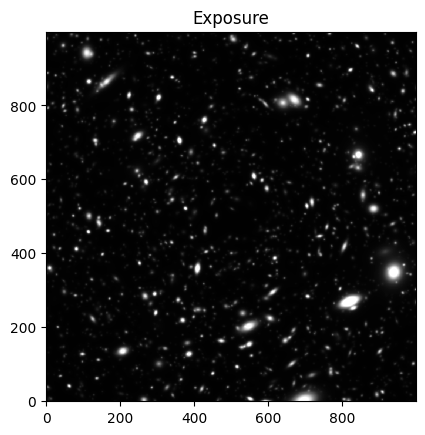

In [74]:
gal_array = np.asarray(
    outcome.outputExposure.getMaskedImage().getImage().array,
    np.float64,
)
lsst_psf = outcome.outputExposure.getPsf()
xc = int(dim // 2)  # we need PSF model without subpixel offset
yc = int(dim // 2)
psf_array = np.asarray(
    anacal.utils.resize_array(
        lsst_psf.computeImage(geom.Point2D(xc, yc)).getArray(), (64, 64)
    ),
    dtype=np.float64,
)


# Display the galaxy image simulation
plt.imshow(
    gal_array,
    aspect="equal",
    cmap="Greys_r",
    origin="lower",
    interpolation="None",
    norm=simple_norm(gal_array, "asinh", asinh_a=0.2, min_cut=-0.1, max_cut=30),
)
plt.title("Exposure")

Text(0.5, 1.0, 'PSF')

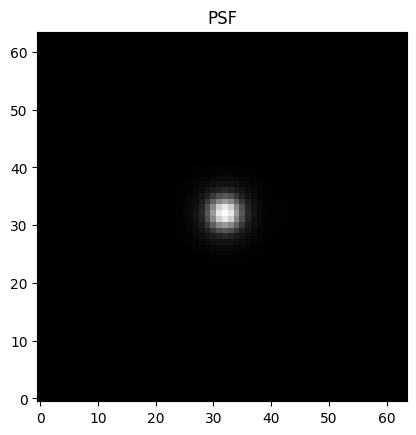

In [75]:
plt.close()
# Display the PSF image simulation
plt.imshow(psf_array, cmap="Greys_r", origin="lower")
plt.title("PSF")

In [76]:
# Run Anacal measurement
fpfs_config = anacal.fpfs.FpfsConfig(
    sigma_arcsec=0.52,  # base measruement kernel (for detection and e1, e2, q1, q2)
    sigma_arcsec1=0.45,  # kernel 1 (for e1_1, e2_1, q1_1, q2_1)
    sigma_arcsec2=0.55,  # kernel 2 (for e1_2, e2_2, q1_2, q2_2)
)
noise_variance = 0.37
out = anacal.fpfs.process_image(
    fpfs_config=fpfs_config,
    mag_zero=mag_zero,
    gal_array=gal_array,
    psf_array=psf_array,
    pixel_scale=pixel_scale,
    noise_variance=noise_variance,  # the detection threshold is determined from this (do not set it to zero)
    noise_array=None,  # image is noiseless, set it to None
    detection=None,  # if set to None, anacal will do detection
)

/tmp/ipykernel_53637/3951392179.py:10: AstropyDeprecationWarning: "min_cut" was deprecated in version 6.1 and will be removed in a future version. Use argument "vmin" instead.
  norm=simple_norm(gal_array, "asinh", asinh_a=0.2, min_cut=-0.1, max_cut=30),
/tmp/ipykernel_53637/3951392179.py:10: AstropyDeprecationWarning: "max_cut" was deprecated in version 6.1 and will be removed in a future version. Use argument "vmax" instead.
  norm=simple_norm(gal_array, "asinh", asinh_a=0.2, min_cut=-0.1, max_cut=30),


Text(0.5, 1.0, 'Exposure')

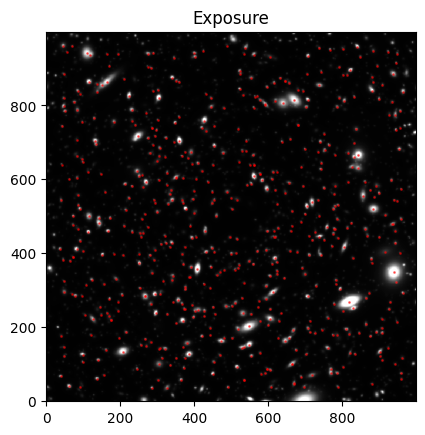

In [77]:
plt.close()
plt.scatter(out["x"], out["y"], marker="o", alpha=0.5, s=1.0, color="red")
# Display the galaxy image simulation
plt.imshow(
    gal_array,
    aspect="equal",
    cmap="Greys_r",
    origin="lower",
    interpolation="None",
    norm=simple_norm(gal_array, "asinh", asinh_a=0.2, min_cut=-0.1, max_cut=30),
)
plt.title("Exposure")

In [78]:
from xlens.summary_pipe.halo_mcbias_multiband import HaloMcBiasMultibandPipe as pipe

In [79]:
out.dtype

dtype([('y', '<f8'), ('x', '<f8'), ('is_peak', '<i4'), ('mask_value', '<i4'), ('fpfs_e1', '<f8'), ('fpfs_de1_dg1', '<f8'), ('fpfs_e2', '<f8'), ('fpfs_de2_dg2', '<f8'), ('fpfs_q1', '<f8'), ('fpfs_dq1_dg1', '<f8'), ('fpfs_q2', '<f8'), ('fpfs_dq2_dg2', '<f8'), ('fpfs_w', '<f8'), ('fpfs_dw_dg1', '<f8'), ('fpfs_dw_dg2', '<f8'), ('fpfs_m00', '<f8'), ('fpfs_dm00_dg1', '<f8'), ('fpfs_dm00_dg2', '<f8'), ('fpfs_m20', '<f8'), ('fpfs_dm20_dg1', '<f8'), ('fpfs_dm20_dg2', '<f8'), ('fpfs1_e1', '<f8'), ('fpfs1_de1_dg1', '<f8'), ('fpfs1_e2', '<f8'), ('fpfs1_de2_dg2', '<f8'), ('fpfs1_q1', '<f8'), ('fpfs1_dq1_dg1', '<f8'), ('fpfs1_q2', '<f8'), ('fpfs1_dq2_dg2', '<f8'), ('fpfs1_m00', '<f8'), ('fpfs1_dm00_dg1', '<f8'), ('fpfs1_dm00_dg2', '<f8'), ('fpfs1_m20', '<f8'), ('fpfs1_dm20_dg1', '<f8'), ('fpfs1_dm20_dg2', '<f8'), ('fpfs2_e1', '<f8'), ('fpfs2_de1_dg1', '<f8'), ('fpfs2_e2', '<f8'), ('fpfs2_de2_dg2', '<f8'), ('fpfs2_q1', '<f8'), ('fpfs2_dq1_dg1', '<f8'), ('fpfs2_q2', '<f8'), ('fpfs2_dq2_dg2', '<f8'), (

In [80]:
e1 = out["fpfs_e1"]
e2 = out["fpfs_e2"]
e1_g1 = out["fpfs_de1_dg1"]
e2_g2 = out["fpfs_de2_dg2"]
w = out["fpfs_w"]
w_g1 = out["fpfs_dw_dg1"]
w_g2 = out["fpfs_dw_dg2"]
x = out["x"]
y = out["y"]

In [81]:
ra, dec = wcs_stack.pixelToSkyArray(x, y, degrees=True)

In [61]:
angle = pipe.position_angle_ccw_from_east(
    200.0,
    0.,
    ra,
    dec
)
dist = pipe.angsep(ra, dec, 200.0, 0.)

In [87]:
eT, eX = pipe._rotate_spin_2_vec(e1, e2, angle)
r11, r22 = pipe._get_response_from_w_and_der(
    e1,
    e2,
    w,
    e1_g1,
    e2_g2,
    w_g1,
    w_g2,
)
rT, rX = pipe._rotate_spin_2_vec(r11, r22, angle)

(array([ 10.,  38.,  63.,  75.,  88.,  77., 104.,  73.,  37.,  18.]),
 array([  3.93192065,  16.47927556,  29.02663047,  41.57398539,
         54.1213403 ,  66.66869521,  79.21605012,  91.76340503,
        104.31075994, 116.85811486, 129.40546977]),
 [<matplotlib.patches.Polygon at 0x7f5992d75790>])

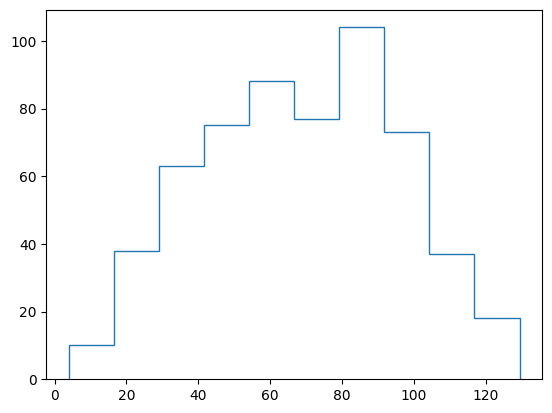

In [88]:
plt.hist(dist, histtype="step")

In [97]:
def get_gT_gX(eT, eX, rT, rX, w, dist, ang_bin_edges):
    eT_list = []
    eX_list = []
    rT_list = []
    rX_list = []
    eT_std_list = []
    eX_std_list = []
    for i in range(len(ang_bin_edges) - 1):
        mask = (dist >= ang_bin_edges[i]) & (dist < ang_bin_edges[i + 1])

        assert np.sum(mask) > 0, f"No data in bin {i} with edges {ang_bin_edges[i]} and {ang_bin_edges[i + 1]}"
        
        eT_sum = np.sum(eT[mask] * w[mask])
        eX_sum = np.sum(eX[mask] * w[mask])

        rT_sum = np.sum(rT[mask])
        rX_sum = np.sum(rX[mask])


        eT_list.append(eT_sum)
        eX_list.append(eX_sum)
        rT_list.append(rT_sum)
        rX_list.append(rX_sum)

        eT_std_list.append(np.std(eT[mask]))
        eX_std_list.append(np.std(eX[mask]))

    gT = np.array(eT_list) / np.array(rT_list) 
    gX = np.array(eX_list) / np.array(rX_list)
    gT_std = np.array(eT_std_list) / np.abs(np.array(rT_list))
    gX_std = np.array(eX_std_list) / np.abs(np.array(rX_list))

    return gT, gX, gT_std, gX_std
        

In [98]:
gT, gX, gT_std, gX_std = get_gT_gX(eT, eX, rT, rX, w, dist, ang_bin_edges)

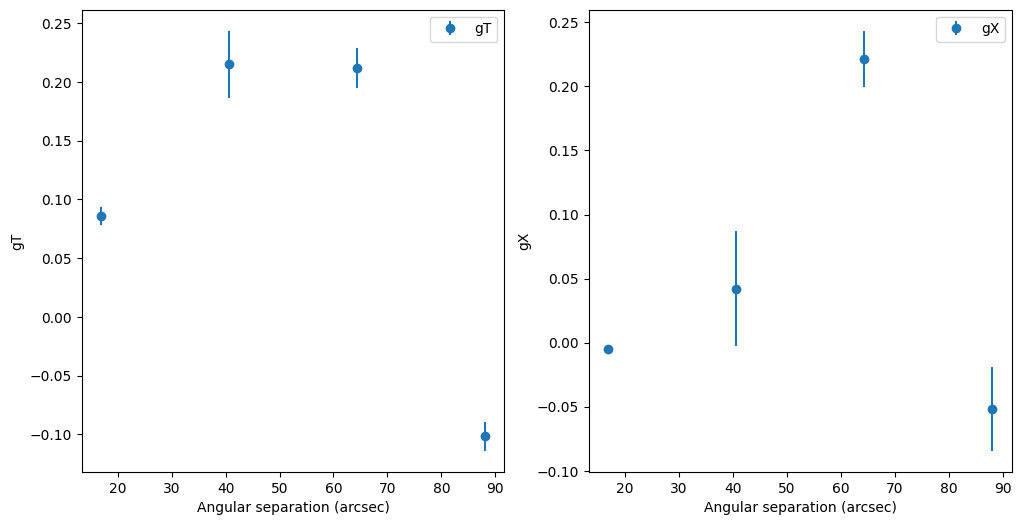

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].errorbar(
    ang_bin_mid,
    gT,
    yerr=gT_std,
    fmt="o",
    label="gT",
)
axes[0].set_xlabel("Angular separation (arcsec)")
axes[0].set_ylabel("gT")
axes[0].legend()
axes[1].errorbar(
    ang_bin_mid,
    gX,
    yerr=gX_std,
    fmt="o",
    label="gX",
)
axes[1].set_xlabel("Angular separation (arcsec)")
axes[1].set_ylabel("gX")
axes[1].legend()